# Drug toxicity screening on human iPSC-derived cardiomyocites

## Background

iPSCs are valuable resource to model drug interactions with different tissue and are frequenly used in drug screens to gain insights into drug specificity and toxicity. Tyrosine kinase inhibitors (TKIs) are frequently used drugs in cancer treatment. Unfortunately, cardiomyopathy may occur as a severe side effect of these drugs due to cardiotoxicity.   
  
Here, you will compare the transcriptomes of iPSC-derived cardiomyocites treated with two different FDA-approved TKIs to investigate their toxicity and gain insights into the biological pathways potentially leading to cardiotoxicity.
- Doxorubicin
- Gefinitib

## Objectives
1. Explore the impact on global gene expression patterns (PCA).
2. Identify differentially expressed genes (DEGs) between mutant and WT for both drugs.
3. Visualized DEGs with volcano plots and heatmaps.
4. Perform GO enrichment to determine affected biological pathways.
5. Interpret the cardiotoxic potential of these drugs, and what cellular mechansims they might disrupt.

In [22]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import scanpy as sc
import anndata as ad
import os
import pandas as pd
import gseapy
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [23]:
counts = pd.read_csv(
    "Session_3_4/split_datasets/counts_msn09_group_5.txt", sep="\t", index_col=0
)
counts

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,CTRL_9,CTRL_10,CTRL_11,DOX_1,DOX_2,DOX_3,GEF_1,GEF_2,GEF_3
DDX11L1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WASH7P,59,13,21,42,152,43,118,35,36,83,27,64,77,41,22,40,34
MIR6859-1,0,2,1,0,0,4,9,3,3,5,6,13,12,11,2,3,7
MIR1302-2HG,0,0,0,0,4,0,0,0,0,0,0,0,1,0,0,1,0
MIR1302-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND6,40897,29946,40197,43915,42077,20136,59381,41136,49069,80854,34107,54961,61237,64244,35113,60571,22651
TRNE,4,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0
CYTB,104482,79893,113648,107667,100521,68123,175119,119598,138978,236109,99562,141777,150432,176396,106566,159021,72299
TRNT,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0


In [24]:
metadata_df = pd.read_csv(
    "Session_3_4/split_datasets/metadata_msn09_group_5.txt", sep="\t", index_col=0
)
metadata_df

,treatment,Concentration,cell_line,cell_type,replicate
CTRL_1,Control,0nM,MSN09,cardiomyocytes,1
CTRL_2,Control,0nM,MSN09,cardiomyocytes,2
CTRL_3,Control,0nM,MSN09,cardiomyocytes,3
CTRL_4,Control,0nM,MSN09,cardiomyocytes,4
CTRL_5,Control,0nM,MSN09,cardiomyocytes,5
CTRL_6,Control,0nM,MSN09,cardiomyocytes,6
CTRL_7,Control,0nM,MSN09,cardiomyocytes,7
CTRL_8,Control,0nM,MSN09,cardiomyocytes,8
CTRL_9,Control,0nM,MSN09,cardiomyocytes,9
CTRL_10,Control,0nM,MSN09,cardiomyocytes,10


# PCA

In [25]:
total_reads = counts.sum(axis=0)
normalized_count_table = (counts / total_reads) * 1000000
log_transformed_counts = np.log2(normalized_count_table + 1)

In [26]:
scaler = StandardScaler()

scaled_table = scaler.fit_transform(log_transformed_counts.T)

In [27]:
pca = PCA()

pca_result_matrix = pca.fit_transform(scaled_table)

In [28]:
np.shape(pca_result_matrix)

(17, 17)

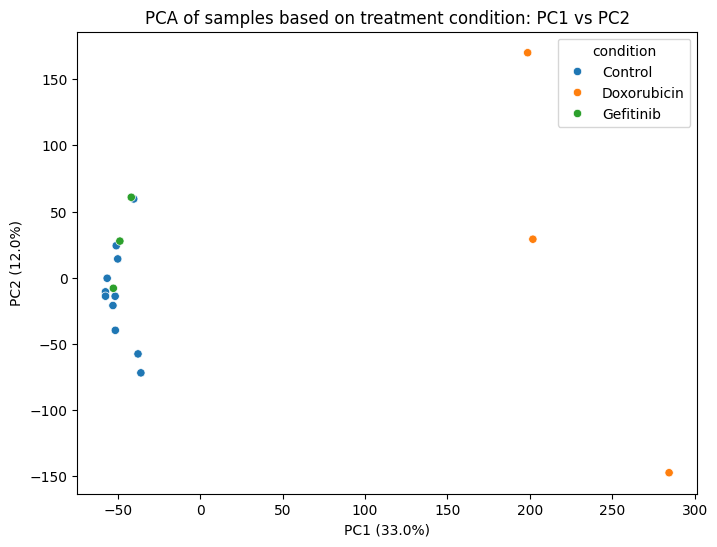

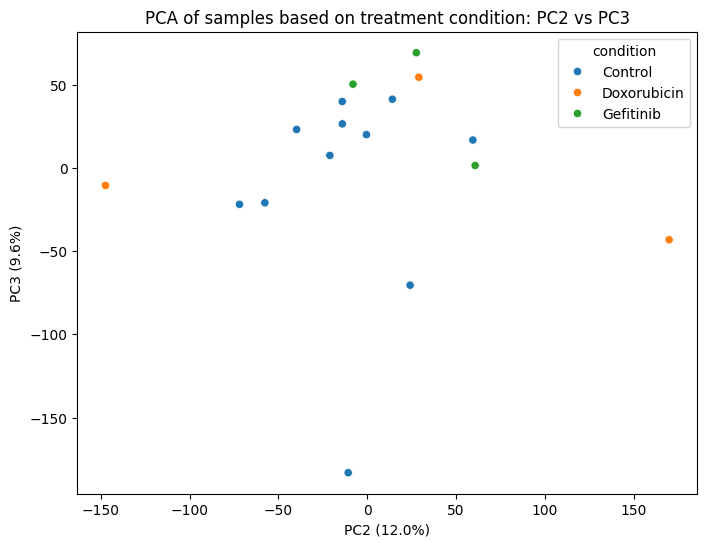

In [29]:
plot_df = pd.DataFrame(
    {
        "PC1": pca_result_matrix[:, 0],
        "PC2": pca_result_matrix[:, 1],
        "PC3": pca_result_matrix[:, 2],
        "condition": metadata_df["treatment"].values,
    }
)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="condition")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
plt.title("PCA of samples based on treatment condition: PC1 vs PC2")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="PC2", y="PC3", hue="condition")
plt.xlabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
plt.ylabel(f"PC3 ({pca.explained_variance_ratio_[2] * 100:.1f}%)")
plt.title("PCA of samples based on treatment condition: PC2 vs PC3")
plt.show()

# DEseq2

## Doxorubicin vs Control

In [30]:
drug = "Doxorubicin"

metadata_df_filtered_dox = metadata_df[metadata_df["treatment"].isin([drug, "Control"])]
counts_filtered_dox = counts[metadata_df_filtered_dox.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_dox.T,
    metadata=metadata_df_filtered_dox,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_dox = DeseqStats(
    deseq_object, contrast=("treatment", "Doxorubicin", "Control")
)
stat_res_dox.summary()
results_df_dox = stat_res_dox.results_df


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.43 seconds.

Fitting dispersion trend curve...
... done in 0.46 seconds.

Fitting MAP dispersions...
... done in 1.47 seconds.

Fitting LFCs...
... done in 1.43 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 167 outlier genes.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.04 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: treatment Doxorubicin vs Control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
DDX11L1           0.000000             NaN       NaN       NaN       NaN   
WASH7P           51.338910       -0.086674  0.404387 -0.214335  0.830286   
MIR6859-1         4.578691        1.675886  0.849487  1.972822  0.048516   
MIR1302-2HG       0.252657       -0.394891  3.850693 -0.102551  0.918320   
MIR1302-2         0.000000             NaN       NaN       NaN       NaN   
...                    ...             ...       ...       ...       ...   
ND6           45108.469519        0.168373  0.202469  0.831600  0.405635   
TRNE              0.418607       -1.952495  3.479965 -0.561068  0.574752   
CYTB         124055.191022        0.064987  0.214981  0.302291  0.762430   
TRNT              0.208044       -1.112739  4.093818 -0.271809  0.785769   
TRNP            987.793621        1.713046  0.415882  4.119066  0.000038   

                

... done in 1.39 seconds.



In [31]:
# Get upregulated and downregulated genes
upregulated_genes_dox = results_df_dox[
    (results_df_dox["log2FoldChange"] > 2) & (results_df_dox["padj"] < 0.05)
]
downregulated_genes_dox = results_df_dox[
    (results_df_dox["log2FoldChange"] < -2) & (results_df_dox["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_dox.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_dox.shape[0]}")

    Upregulated genes: 3047
    Downregulated genes: 1314


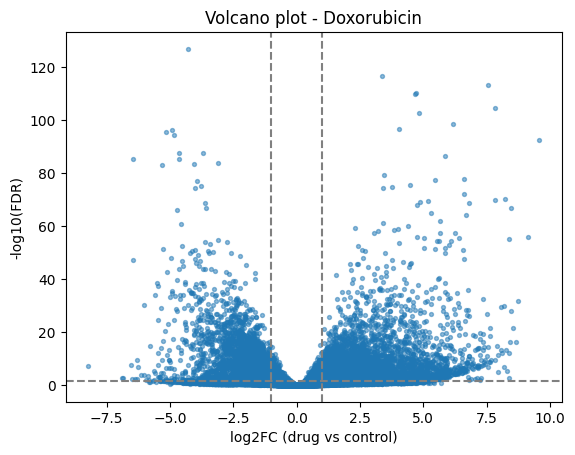

In [32]:
plt.scatter(
    results_df_dox.log2FoldChange, -np.log10(results_df_dox.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (drug vs control)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - {drug}")
plt.show()

## Gefinitib vs Control

In [33]:
drug = "Gefitinib"

metadata_df_filtered_gef = metadata_df[metadata_df["treatment"].isin([drug, "Control"])]
counts_filtered_gef = counts[metadata_df_filtered_gef.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_gef.T,
    metadata=metadata_df_filtered_gef,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_gef = DeseqStats(deseq_object, contrast=("treatment", "Gefitinib", "Control"))
stat_res_gef.summary()
results_df_gef = stat_res_gef.results_df


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.39 seconds.

Fitting dispersion trend curve...
... done in 0.46 seconds.

Fitting MAP dispersions...
... done in 1.37 seconds.

Fitting LFCs...
... done in 1.49 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 95 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: treatment Gefitinib vs Control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
DDX11L1           0.000000             NaN       NaN       NaN       NaN   
WASH7P           45.019869       -0.331799  0.409370 -0.810511  0.417647   
MIR6859-1         3.275361        0.782607  0.990738  0.789923  0.429573   
MIR1302-2HG       0.252986        0.288936  3.851379  0.075022  0.940198   
MIR1302-2         0.000000             NaN       NaN       NaN       NaN   
...                    ...             ...       ...       ...       ...   
ND6           41136.920981        0.198988  0.235964  0.843299  0.399061   
TRNE              0.378395       -1.269378  3.465781 -0.366260  0.714171   
CYTB         115800.183916        0.240913  0.227564  1.058665  0.289752   
TRNT              0.189643       -0.430911  4.094539 -0.105240  0.916185   
TRNP            590.362346       -0.150839  0.401659 -0.375539  0.707260   

                 p

... done in 1.36 seconds.



In [34]:
# Get upregulated and downregulated genes
upregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] > 2) & (results_df_gef["padj"] < 0.05)
]
downregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] < -2) & (results_df_gef["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_gef.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_gef.shape[0]}")

    Upregulated genes: 0
    Downregulated genes: 15


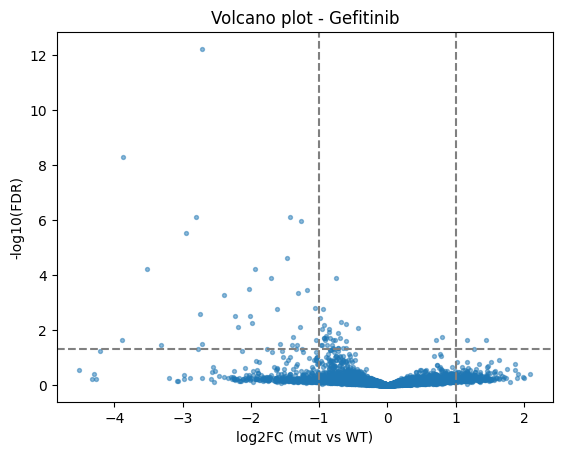

In [35]:
plt.scatter(
    results_df_gef.log2FoldChange, -np.log10(results_df_gef.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (mut vs WT)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - {drug}")
plt.show()

# GSEAPY

In [36]:
GO_databases = [
    "GO_Biological_Process_2025",
    "GO_Cellular_Component_2025",
    "GO_Molecular_Function_2025",
]

## Doxorubicin vs Control

In [37]:
go_upr_results_dox = {}
go_dwr_results_dox = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_dox.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_dox[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_dox.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_dox[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error


    GO_Biological_Process_2025
    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


### Plot upregulated GO terms

In [38]:
for k, v in go_upr_results_dox.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k[0], k[1]} \n {k[2]} \n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

GO_Biological_Process_2025: (3525, 10)
Error occurred while plotting GO_Biological_Process_2025: Warning: No enrich terms when cutoff = 0.05
GO_Cellular_Component_2025: (295, 10)
Error occurred while plotting GO_Cellular_Component_2025: Warning: No enrich terms when cutoff = 0.05
GO_Molecular_Function_2025: (735, 10)
Error occurred while plotting GO_Molecular_Function_2025: Warning: No enrich terms when cutoff = 0.05


In [39]:
display(go_upr_results_dox["GO_Biological_Process_2025"].head(5))

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2025,Peripheral Nervous System Neuron Development (...,4/5,0.002362,0.999996,0,0,22.283273,134.777416,ISL2;POU4F1;RUNX3;RUNX1
1,GO_Biological_Process_2025,TRAIL-activated Apoptotic Signaling Pathway (G...,4/8,0.022508,0.999996,0,0,5.569832,21.131365,SPI1;TNFRSF10C;TNFRSF10B;TNFRSF10A
2,GO_Biological_Process_2025,Cell Differentiation Involved in Metanephros D...,4/8,0.022508,0.999996,0,0,5.569832,21.131365,SALL1;PAX8;STAT1;SIX2
3,GO_Biological_Process_2025,Regulation of Nephron Tubule Epithelial Cell D...,4/8,0.022508,0.999996,0,0,5.569832,21.131365,PAX8;LHX1;LIF;GATA3
4,GO_Biological_Process_2025,Sensory Perception of Sour Taste (GO:0050915),4/8,0.022508,0.999996,0,0,5.569832,21.131365,SCNN1D;PKD2L1;PKD1L3;ASIC2


### Plot downregulated GO terms

GO_Biological_Process_2025: (3103, 10)
GO_Cellular_Component_2025: (255, 10)
GO_Molecular_Function_2025: (626, 10)
Error occurred while plotting GO_Molecular_Function_2025: Warning: No enrich terms when cutoff = 0.05


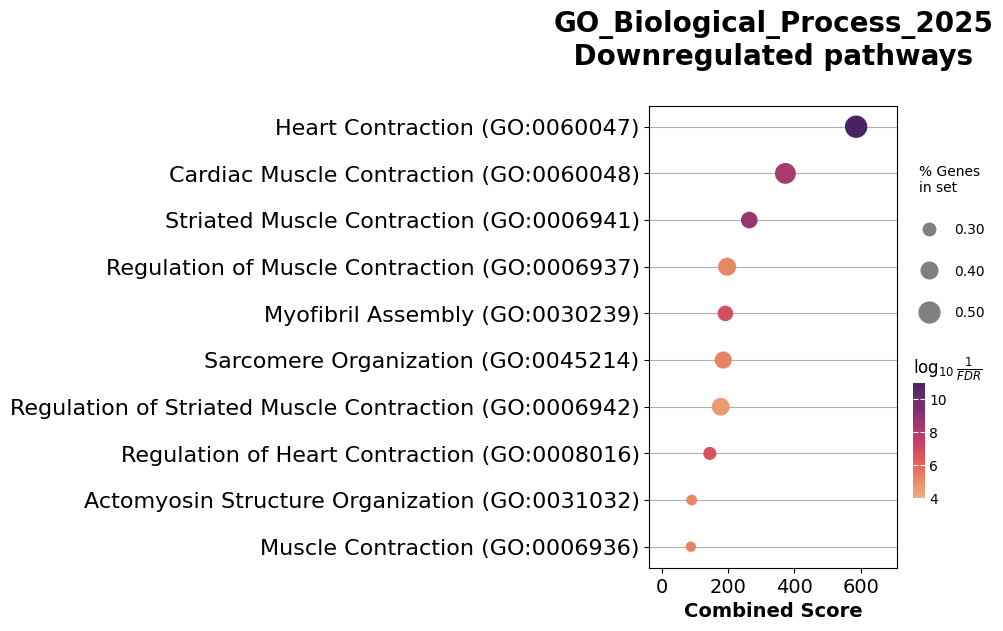

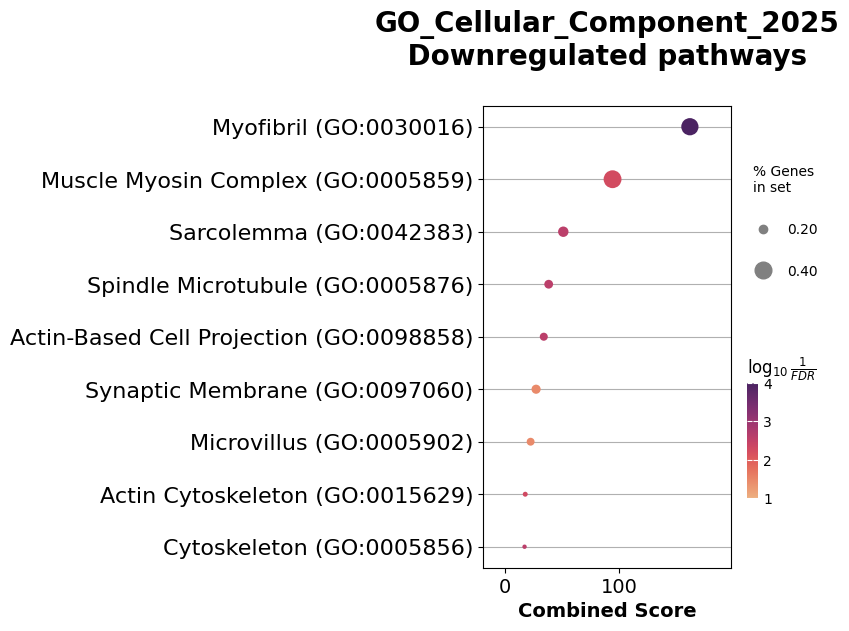

In [40]:
for k, v in go_dwr_results_dox.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k}\n Downregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

In [41]:
# Check out all results for downregulated GO terms (biological process)
go_dwr_results_dox["GO_Biological_Process_2025"][
    go_dwr_results_dox["GO_Biological_Process_2025"]["Adjusted P-value"] < 0.05
]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2025,Heart Contraction (GO:0060047),22/41,5.977019e-16,1.854669e-12,0,0,16.729428,586.423995,MYBPC3;RYR2;TPM1;ATP1A2;SLC8A1;MYL4;SGCD;ACTC1...
1,GO_Biological_Process_2025,Striated Muscle Contraction (GO:0006941),22/55,1.302785e-12,2.021271e-09,0,0,9.624871,263.399193,MYBPC3;CHRNA1;RYR2;SMPX;TPM1;ATP1A2;RCSD1;SLC8...
2,GO_Biological_Process_2025,Cardiac Muscle Contraction (GO:0060048),17/34,5.726595e-12,5.923208e-09,0,0,14.393986,372.601285,MYBPC3;RYR2;TPM1;SLC8A1;MYL4;KCNQ1;MYL2;TNNT2;...
3,GO_Biological_Process_2025,Myofibril Assembly (GO:0030239),19/51,1.925687e-10,1.493852e-07,0,0,8.552751,191.329897,MYBPC3;MYOM1;ADPRHL1;TMOD2;TPM1;LMOD1;MYBPH;MY...
4,GO_Biological_Process_2025,Regulation of Heart Contraction (GO:0008016),22/70,3.311453e-10,2.055088e-07,0,0,6.611778,144.324949,CYP2J2;RYR2;CAV3;KCNIP1;HSPB7;TPM1;ATP2B4;ANK2...
5,GO_Biological_Process_2025,Sarcomere Organization (GO:0045214),14/34,1.043835e-08,4.999639e-06,0,0,10.050923,184.713648,MYBPC3;MYOM1;TPM1;MYBPH;MYLK3;MYOM2;LMOD2;OBSC...
6,GO_Biological_Process_2025,Muscle Contraction (GO:0006936),24/97,1.127859e-08,4.999639e-06,0,0,4.743676,86.810982,GAMT;RYR2;OXTR;SMPX;KCNIP1;TMOD2;TPM1;MYOF;LMO...
7,GO_Biological_Process_2025,Regulation of Muscle Contraction (GO:0006937),13/30,1.672033e-08,6.485398e-06,0,0,10.973324,196.495362,CHRM2;MYBPC3;TPM1;MYBPH;CACNA1C;CNN1;TNNT1;MYL...
8,GO_Biological_Process_2025,Actomyosin Structure Organization (GO:0031032),22/85,1.881235e-08,6.486080e-06,0,0,5.033491,89.539518,MYBPC3;MYOM1;TMOD2;TPM1;LMOD1;MYBPH;ARRB1;MYLK...
9,GO_Biological_Process_2025,Regulation of Striated Muscle Contraction (GO:...,12/28,6.977935e-08,2.165253e-05,0,0,10.754608,177.213658,MYBPC3;RYR2;CAV3;GJA5;MYL2;RNF207;MYL3;TNNI1;M...


## Gefitinib vs Control

In [42]:
go_upr_results_gef = {}
go_dwr_results_gef = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_gef[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_gef[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error


    GO_Biological_Process_2025
    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


In [43]:
print(go_upr_results_gef)
print(go_dwr_results_gef)

{}
{}


In [44]:
# --> no enriched pathways found

### Plot upregulated GO terms

In [45]:
for k, v in go_upr_results_gef.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k[0], k[1]} \n {k[2]} \n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

### Plot downregulated GO terms

In [46]:
for k, v in go_dwr_results_gef.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k}\n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")